In [1]:
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

import shap

In [4]:
# 获取当前目录
current_dir = os.getcwd()

file_list = []
# 遍历当前目录及其子目录
for root, dirs, files in os.walk(current_dir):
    for file in files:
        if file.endswith(".mat"):
           file_list.append(file)

In [5]:
file_list.sort()
file_list

['CONE_D1_C_Fea_keli_4_hh.mat',
 'CONE_D1_C_Fea_keli_4_vv.mat',
 'CONE_D1_S_Fea_keli_4_hh.mat',
 'CONE_D1_S_Fea_keli_4_vv.mat',
 'CONE_D1_X_Fea_keli_4_hh.mat',
 'CONE_D1_X_Fea_keli_4_vv.mat',
 'CONE_D2_C_Fea_keli_4_hh.mat',
 'CONE_D2_C_Fea_keli_4_vv.mat',
 'CONE_D2_S_Fea_keli_4_hh.mat',
 'CONE_D2_S_Fea_keli_4_vv.mat',
 'CONE_D2_X_Fea_keli_4_hh.mat',
 'CONE_D2_X_Fea_keli_4_vv.mat',
 'CONE_D3_C_Fea_keli_4_hh.mat',
 'CONE_D3_C_Fea_keli_4_vv.mat',
 'CONE_D3_S_Fea_keli_4_hh.mat',
 'CONE_D3_S_Fea_keli_4_vv.mat',
 'CONE_D3_X_Fea_keli_4_hh.mat',
 'CONE_D3_X_Fea_keli_4_vv.mat',
 'CONE_D4_C_Fea_keli_4_hh.mat',
 'CONE_D4_C_Fea_keli_4_vv.mat',
 'CONE_D4_S_Fea_keli_4_hh.mat',
 'CONE_D4_S_Fea_keli_4_vv.mat',
 'CONE_D4_X_Fea_keli_4_hh.mat',
 'CONE_D4_X_Fea_keli_4_vv.mat',
 'CONE_D5_C_Fea_keli_4_hh.mat',
 'CONE_D5_C_Fea_keli_4_vv.mat',
 'CONE_D5_S_Fea_keli_4_hh.mat',
 'CONE_D5_S_Fea_keli_4_vv.mat',
 'CONE_D5_X_Fea_keli_4_hh.mat',
 'CONE_D5_X_Fea_keli_4_vv.mat',
 'CONE_L1_C_Fea_keli_4_hh.mat',
 'CONE_L

In [6]:
L_fix = [0.03, 1]
D_fix = [4, 0.03]
R_fix = [4, 1]

In [7]:
L_change = [1, 1.3, 1.8, 2.3, 2.8, 3.3, 3.8, 4.3, 4.8]
D_change = [0.5, 0.8, 1.3, 1.8, 2.3]
R_change = [0.005, 0.02, 0.045, 0.07, 0.095]

In [8]:
angle = np.linspace(0, 180, 91)

In [9]:
L_param = np.array([L_fix+[item] for item in [item for item in L_change for _ in range(2)]])
D_param = np.array([[item] + D_fix for item in [item for item in D_change for _ in range(2)]])
R_param = np.array([[R_fix[0]]+[item]+[R_fix[1]] for item in [item for item in R_change for _ in range(2)]])

L_param = np.vstack([L_param, L_param, L_param])
D_param = np.vstack([D_param, D_param, D_param])
R_param = np.vstack([R_param, R_param, R_param])

In [10]:
print(L_param.shape, D_param.shape, R_param.shape)

(54, 3) (30, 3) (30, 3)


In [11]:
# 要复制的份数
k = len(angle)


# 初始化结果列表
L_arr = []

# 遍历原数组中的每一行
for row in L_param:
    # 遍历每一个要添加的元素
    for element in angle:
        # 将原行与新元素结合，并添加到结果中
        new_row = np.append(row, element)
        L_arr.append(new_row)

L_arr = np.array(L_arr)

# 初始化结果列表
D_arr = []

# 遍历原数组中的每一行
for row in D_param:
    # 遍历每一个要添加的元素
    for element in angle:
        # 将原行与新元素结合，并添加到结果中
        new_row = np.append(row, element)
        D_arr.append(new_row)

D_arr = np.array(D_arr)

# 初始化结果列表
R_arr = []

# 遍历原数组中的每一行
for row in R_param:
    # 遍历每一个要添加的元素
    for element in angle:
        # 将原行与新元素结合，并添加到结果中
        new_row = np.append(row, element)
        R_arr.append(new_row)

R_arr = np.array(R_arr)

In [12]:
print(L_arr.shape, D_arr.shape, R_arr.shape)

(4914, 4) (2730, 4) (2730, 4)


In [13]:
channel_list = ['C']*182 + ['S']*182 + ['X']*182
channel_list = channel_list * 19
len(channel_list)

10374

In [14]:
polar_list = ['hh']*91 + ['vv']*91 
polar_list = polar_list * 57
len(polar_list)

10374

In [15]:
encoder = OneHotEncoder()
encoded_cats = encoder.fit_transform(np.hstack([np.array([channel_list]).reshape(-1, 1), np.array([polar_list]).reshape(-1, 1)]))
encoded_cats = encoded_cats.toarray()

In [16]:
encoded_cats.shape

(10374, 5)

In [17]:
nonclass_feature = np.vstack([D_arr, L_arr, R_arr])
nonclass_feature.shape

(10374, 4)

In [18]:
X_feature = np.hstack([nonclass_feature, encoded_cats])

In [19]:
X_feature

array([[0.5  , 4.   , 0.03 , ..., 0.   , 1.   , 0.   ],
       [0.5  , 4.   , 0.03 , ..., 0.   , 1.   , 0.   ],
       [0.5  , 4.   , 0.03 , ..., 0.   , 1.   , 0.   ],
       ...,
       [4.   , 0.095, 1.   , ..., 1.   , 0.   , 1.   ],
       [4.   , 0.095, 1.   , ..., 1.   , 0.   , 1.   ],
       [4.   , 0.095, 1.   , ..., 1.   , 0.   , 1.   ]])

In [4]:
X_feature.shape

NameError: name 'X_feature' is not defined

In [2]:
y_list = []

for file in file_list:
    data = scipy.io.loadmat(file)
    mean = data['fea_jing'][0][0][0][0][0][-3].reshape(-1,)
    y_list.append(mean)

total_y = np.array(y_list).reshape(114*91, 1)

SyntaxError: invalid syntax (2364348581.py, line 6)

In [3]:
total_y

NameError: name 'total_y' is not defined

In [125]:
dtype=[('temNum', 'O'), ('mean', 'O'), ('std', 'O'), ('max', 'O'), ('min', 'O'), ('range', 'O'), ('prctile10', 'O'), ('prctile50', 'O'), ('prctile90', 'O'), ('sm', 'O'), ('cv', 'O'), ('skew', 'O'), ('kurt', 'O'), ('mellinm', 'O'), ('mellins', 'O'), ('specm', 'O'), ('corrm', 'O'), ('specmm', 'O'), ('corrmm', 'O'), ('spec', 'O'), ('corr', 'O'), ('cor', 'O'), ('corm', 'O'), ('powspecm', 'O'), ('powsp_entropy', 'O'), ('ecc', 'O'), ('mean_dB', 'O'), ('std_dB', 'O'), ('prctile20', 'O'), ('prctile80', 'O'), ('mellin', 'O'), ('powspec_entropy', 'O')]

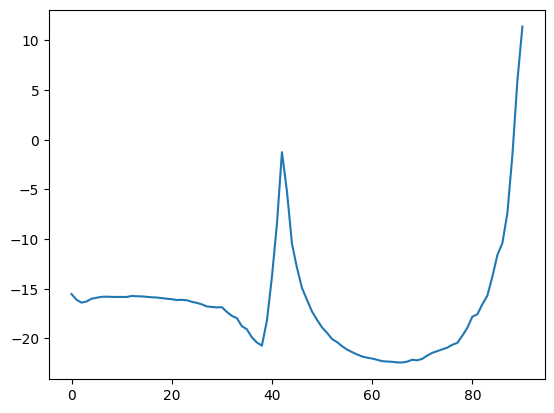

In [126]:
# data['fea_jing'][0][0][0][0][0][1]
# plt.plot(data['fea_jing'][0][0][0][0][0][1].reshape(-1,))
plt.plot(data['fea_jing'][0][0][0][0][0][-4].reshape(-1,))
# plt.plot(data['fea_jing'][0][0][0][0][0][-3].reshape(-1,))
# plt.plot(data['fea_jing'][0][0][0][0][0][7].reshape(-1,))
# plt.plot(data['fea_jing'][0][0][0][0][0][3].reshape(-1,))
# plt.plot(data['fea_jing'][0][0][0][0][0][4].reshape(-1,))
# plt.plot(data['fea_jing'][0][0][0][0][0][8].reshape(-1,))

In [127]:
y_feature = total_y.reshape(-1,)

In [128]:
# 分割数据集
# X_train, X_test, y_train, y_test = train_test_split(X_feature, y_feature, test_size=0.2, random_state=42)

# X_train = X_feature[:90*91]
# X_test = X_feature[90*91:]
# y_train = y_feature[:90*91]
# y_test = y_feature[90*91:]

X_train = X_feature[:108*91]
X_test = X_feature[108*91:]
y_train = y_feature[:108*91]
y_test = y_feature[108*91:]

In [129]:
# 转换为PyTorch的张量
x_tensor = torch.from_numpy(X_train)
y_tensor = torch.from_numpy(y_train)


In [130]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 创建模型实例
input_dim = X_train.shape[1]
model = RegressionModel(input_dim)

In [131]:
class QuantileLoss(nn.Module):
    def __init__(self, quantile):
        super(QuantileLoss, self).__init__()
        self.quantile = quantile

    def forward(self, y_pred, y_true):
        errors = y_true - y_pred
        loss = torch.max((self.quantile - 1) * errors, self.quantile * errors)
        return torch.mean(loss)

In [132]:
# 将数据转换为PyTorch张量
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# 创建数据加载器
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 定义损失函数和优化器
# criterion = nn.MSELoss()
criterion = nn.L1Loss()
# criterion = QuantileLoss(quantile=0.5)
# criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 400
for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        # 前向传播
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/400], Loss: 7.2531
Epoch [20/400], Loss: 6.5844
Epoch [30/400], Loss: 5.7774
Epoch [40/400], Loss: 4.4140
Epoch [50/400], Loss: 4.7511
Epoch [60/400], Loss: 3.7293
Epoch [70/400], Loss: 4.5159
Epoch [80/400], Loss: 4.2769
Epoch [90/400], Loss: 3.1512
Epoch [100/400], Loss: 4.7289
Epoch [110/400], Loss: 3.9830
Epoch [120/400], Loss: 3.1157
Epoch [130/400], Loss: 3.6242
Epoch [140/400], Loss: 4.0991
Epoch [150/400], Loss: 2.7868
Epoch [160/400], Loss: 4.4874
Epoch [170/400], Loss: 3.1758
Epoch [180/400], Loss: 3.1953
Epoch [190/400], Loss: 3.0560
Epoch [200/400], Loss: 5.5307
Epoch [210/400], Loss: 2.8291
Epoch [220/400], Loss: 1.8763
Epoch [230/400], Loss: 1.5747
Epoch [240/400], Loss: 5.7877
Epoch [250/400], Loss: 2.1815
Epoch [260/400], Loss: 3.5099
Epoch [270/400], Loss: 3.1352
Epoch [280/400], Loss: 2.7658
Epoch [290/400], Loss: 3.1266
Epoch [300/400], Loss: 1.9734
Epoch [310/400], Loss: 3.2094
Epoch [320/400], Loss: 3.1976
Epoch [330/400], Loss: 2.6672
Epoch [340/400], Lo

In [133]:
torch.save(model.state_dict(), 'mlp_prediction.pth')
# 模型评估
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    test_loss = criterion(predictions, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 3.6837


In [ ]:
predict_first = model(torch.tensor(X_feature, dtype=torch.float32)[-182:]).detach().numpy().reshape(-1,)
first = y_feature[-182:]

# predict_first = model(torch.tensor(X_feature, dtype=torch.float32)[-1092:-546]).detach().numpy().reshape(-1,)
# first = y_feature[-1092:-546]

plt.figure(figsize=(12, 9))
# 可视化结果
plt.plot(first, 'r-', label='Original data')
plt.plot(predict_first, 'b-', label='Fitted line')
plt.legend()
plt.show()

In [97]:
print(np.mean(np.abs((predict_first-first)/first)))

0.397581357766684


In [72]:
np.min(np.abs((predict_first-first)/first))

0.00022081798911949225

In [28]:
seq = [(0, 896), (896, 2096), (2096, 2811), (2811, 4011), (4011, 5211), (5211, 6411), (6411, 7611), (7611, 8811), (8811, 9788), (9788, 10988), (10988, 12188), (12188, 13388), (13388, 14588), (14588, 15710), (15710, 16910), (16910, 17625), (17625, 18825), (18825, 20025), (20025, 21225), (21225, 22121), (22121, 23321), (23321, 24521), (24521, 25721), (25721, 26921), (26921, 28121), (28121, 29243), (29243, 30443), (30443, 31420), (31420, 32620), (32620, 33335)]

In [29]:
sum([end - start - 100 + 1 for start, end in seq])

30365

In [30]:
def predict_function(X):
    # 将numpy数组转换为PyTorch张量
    X_tensor = torch.tensor(X, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        y_pred = model(X_tensor).numpy()
    return y_pred

In [31]:
# print the JS visualization code to the notebook
shap.initjs()


In [32]:
indices = np.arange(len(X_train))
np.random.shuffle(indices)
explainer = shap.KernelExplainer(predict_function, X_train[indices][:100])
# explainer = shap.KernelExplainer(predict_function, X_train[:100])
# explainer = shap.KernelExplainer(predict_function, X_train[:100])

In [33]:
shap_values = explainer.shap_values(X_test, nsamples=500)

  0%|          | 0/546 [00:00<?, ?it/s]

In [52]:
shap_values = explainer(X_test)

  0%|          | 0/546 [00:00<?, ?it/s]

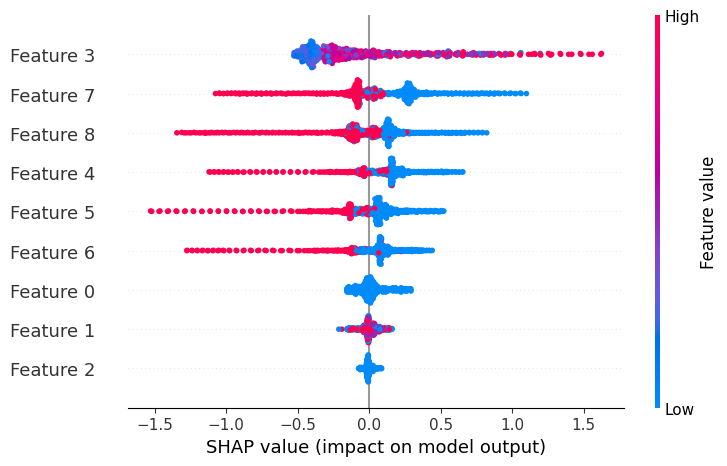

In [56]:
shap.plots.beeswarm(shap_values[:, :, 0])

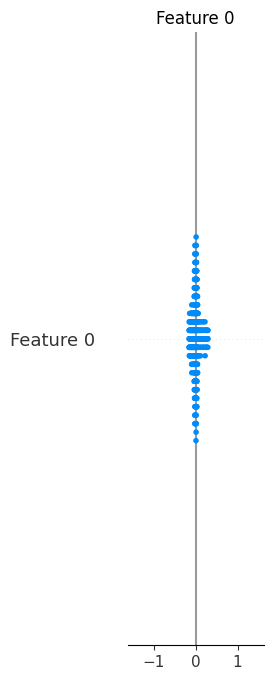

In [54]:
shap.summary_plot(shap_values, X_test)

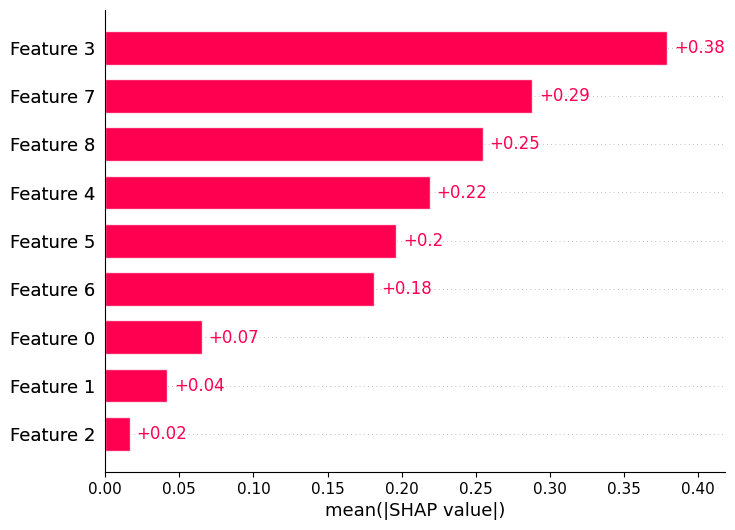

In [57]:

shap.plots.bar(shap_values[:, :, 0])

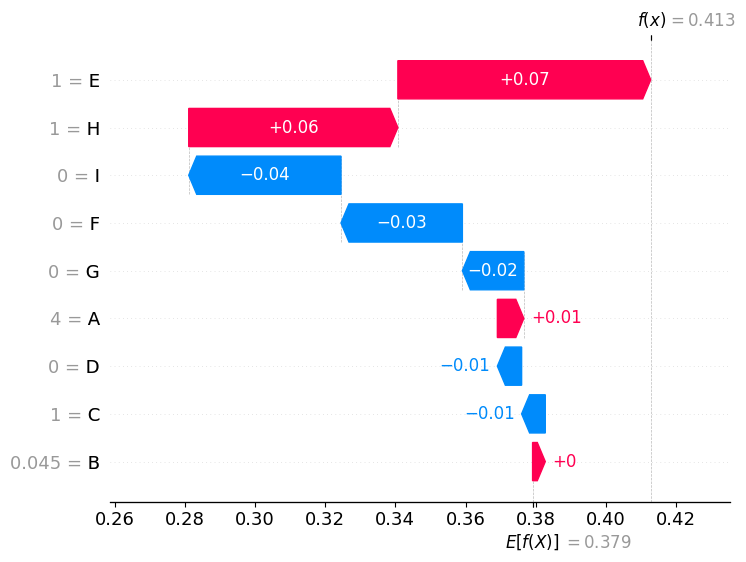

In [44]:

# 选择一个样本进行可视化
sample_index = 0
# shap_values_np = [val.numpy() for val in shap_values]  # 转换为 Numpy 数组
base_value = np.mean(y_train)  # 基准值

# 创建 SHAP Explanation 对象
shap_explanation = shap.Explanation(
    # values=shap_values[500].reshape(-1,),  # 类别 0 的 SHAP 值
    values=np.mean(shap_values,0).reshape(-1,), 
    base_values=base_value,
    data=X_test[sample_index],
    feature_names=['A','B','C','D','E','F','G','H','I']
)

# 绘制 Waterfall 图
shap.waterfall_plot(shap_explanation)

plt.show()

In [36]:
shap.force_plot(explainer.expected_value[0], shap_values[0][:,0], X_test[10,:])

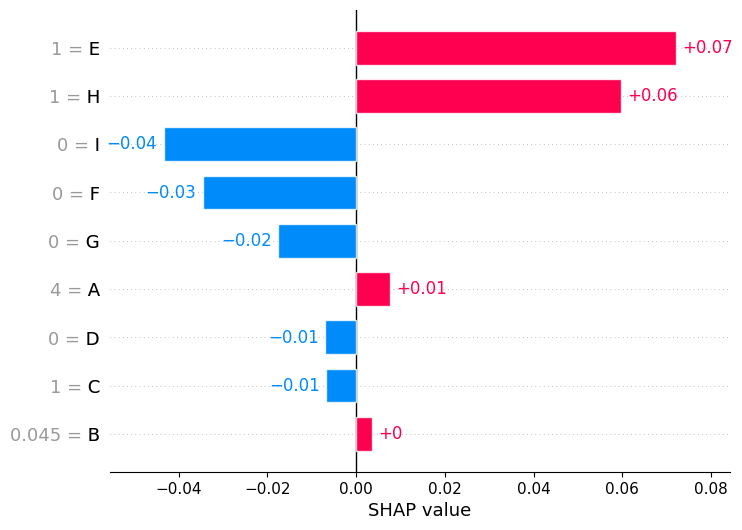

In [39]:
shap.plots.bar(shap_explanation)

In [ ]:
# Assuming you have your original shap_values and features
shap_values_exp = shap.Explanation(values=shap_values, feature_names=feature_names)

# Now pass the shap.Explanation object to shap.plots.bar
shap.plots.bar(shap_values_exp)

In [ ]:
X_test.shape

In [38]:
shap_values.shape

(546, 9, 1)

In [ ]:
np.mean(shap_values[0], axis=0)